In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"paras110","key":"edc195d720fc33aca45dd679974f5435"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images -p /content --unzip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
 86% 102M/119M [00:00<00:00, 225MB/s] 
100% 119M/119M [00:00<00:00, 241MB/s]


In [ ]:
import os

os.listdir('/content/Data')


['test', 'valid', 'train']

In [ ]:
test_folder = '/content/Data/test'
train_folder = '/content/Data/train'
val_folder = '/content/Data/valid'

test_classes = os.listdir(test_folder)

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

In [ ]:
train_ds = trainGenertor.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

validation_ds = valGenertor.flow_from_directory(
    val_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_ds = testGenertor.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
VGG16_model = tf.keras.applications.VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = (224,224,3)
)
for layer in VGG16_model.layers :
  layer.trainable = False

In [ ]:


from keras import activations
pretrained_model = Sequential()

pretrained_model= Sequential()
pretrained_model.add(VGG16_model)
pretrained_model.add(BatchNormalization())
pretrained_model.add(MaxPooling2D((2,2)))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(1024,activation = 'relu'))
pretrained_model.add(Dropout(0.3))
pretrained_model.add(Dense(512,activation = 'relu'))
pretrained_model.add(Dropout(0.3))
pretrained_model.add(Dense(256,activation = 'relu'))
pretrained_model.add(Dense(128,activation = 'relu'))
pretrained_model.add(Dense(4,activation = 'softmax'))

In [ ]:
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [ ]:
pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]


In [ ]:
history = pretrained_model.fit(train_ds, epochs = 50, validation_data = validation_ds,verbose = 1)

Epoch 1/50
39/39 [==============================] - 20s 466ms/step - loss: 1.4958 - accuracy: 0.4029 - val_loss: 2.1157 - val_accuracy: 0.4861
Epoch 2/50
39/39 [==============================] - 15s 376ms/step - loss: 1.0636 - accuracy: 0.5530 - val_loss: 1.1238 - val_accuracy: 0.4444
Epoch 3/50
39/39 [==============================] - 15s 376ms/step - loss: 0.8650 - accuracy: 0.6150 - val_loss: 0.8363 - val_accuracy: 0.6667
Epoch 4/50
39/39 [==============================] - 15s 391ms/step - loss: 0.8852 - accuracy: 0.6215 - val_loss: 0.7730 - val_accuracy: 0.6806
Epoch 5/50
39/39 [==============================] - 15s 384ms/step - loss: 0.7530 - accuracy: 0.7015 - val_loss: 0.8228 - val_accuracy: 0.6667
Epoch 6/50
39/39 [==============================] - 15s 375ms/step - loss: 0.7131 - accuracy: 0.6933 - val_loss: 0.8316 - val_accuracy: 0.6111
Epoch 7/50
39/39 [==============================] - 15s 372ms/step - loss: 0.6648 - accuracy: 0.7308 - val_loss: 0.5529 - val_accuracy: 0.7778

In [ ]:
test_loss, test_accuracy = pretrained_model.evaluate(test_ds,verbose =1)
print(f'Test accuracy: {test_accuracy}')

20/20 [==============================] - 6s 289ms/step - loss: 0.4437 - accuracy: 0.8730
Test accuracy: 0.8730158805847168


In [ ]:
import seaborn as sns
predictions_prob = pretrained_model.predict(test_ds)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_ds.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 2s 117ms/step
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       120
           1       0.74      0.96      0.84        51
           2       1.00      0.98      0.99        54
           3       0.82      0.89      0.86        90

    accuracy                           0.87       315
   macro avg       0.88      0.90      0.88       315
weighted avg       0.89      0.87      0.87       315



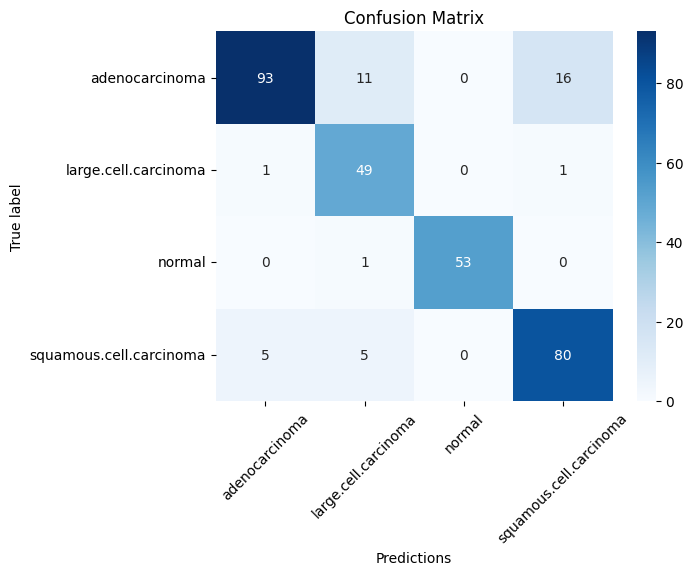

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

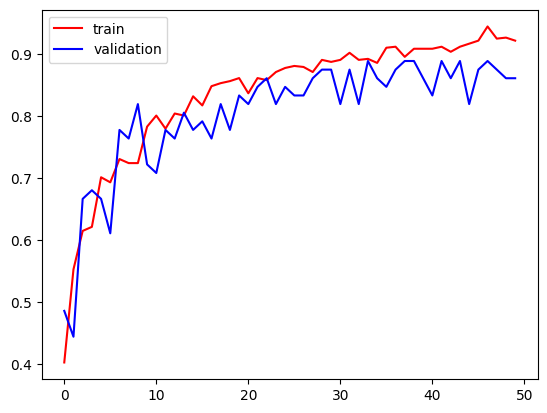

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

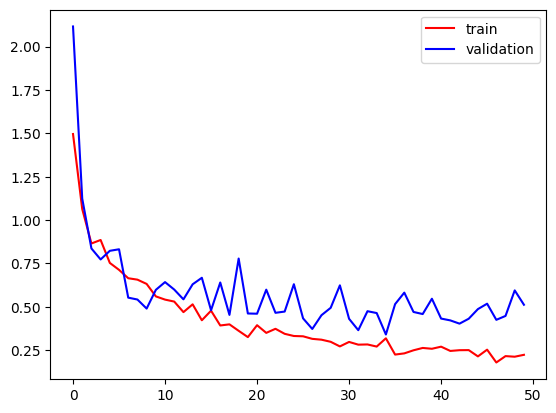

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

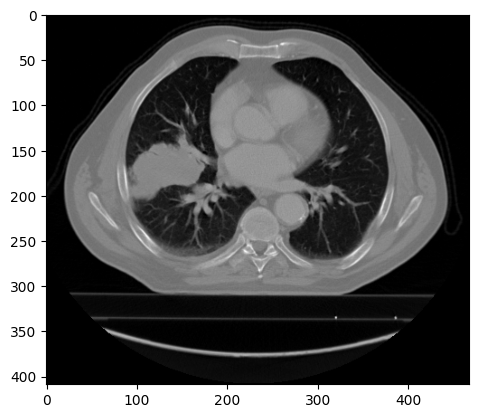

In [ ]:
import cv2
test_img = cv2.imread('/content/Data/test/adenocarcinoma/000118 (5).png')

plt.imshow(test_img)

1/1 [==============================] - 0s 35ms/step


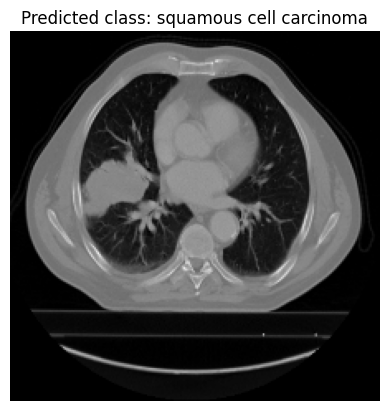

In [ ]:
test_img.shape

test_img = cv2.resize(test_img,(224,224))
test_input = test_img.reshape((1,224,224,3))

predictions = pretrained_model.predict(test_input)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Plot the image with the predicted class label
plt.imshow(test_img)
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()